# LPJ-GUESS forest age initialization
### based on HILDA+ & forest age structure observations

- step by step documentation and code of forest age initialization setup

The idea of this forest age initialization approach: In order to bring LPJ-GUESS forest age structure close to observations, land use change (LUC) events from NATURAL to FOREST are introduced. This happens based on HILDA+ land use. In a firest step, forest age structure forced by natural disturbances as well as LUC from HILDA+ is calculated. Then, the difference between this forest age structure and observed forest age structure is analyzed. Based on this difference, harvest events are introduced in order to minimize these differences. These calculated harvest events are transformed into land use input files for LPJ-GUESS. 

## Import necessary libraries and data

For the code snippets some libraries need to be imported

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as nc
import rasterio

import python scripts with functions I wrote for forest age initialization and gross stand type transfer matrix

In [5]:
import gross_st_matrix_hildaplus as st
import age_init as ag

## HILDA+

HILDA+ is a remote sensing based land use data set, see: https://landchange.imk-ifu.kit.edu/hilda

About the HILDA+ spatial dataset:
- Format: GeoTIFF and NetCDF
- Projection:  EPSG: 4326 - WGS 84 – Geographic
- Spatial coverage/extent: -180, 90, 180, -90 ° (Global)
- Temporal coverage: 1899-2019/ 1960-2019/20
- Spatial resolution:  1 km
- Temporal resolution:  1 year
- Class codes (for stable categories): 00 ocean, 11 urban, 22 cropland, 33 pasture/rangeland, 44 forest, 55 unmanaged grass/shrubland, 66 sparse/no vegetation, 77 water, 99 no data

In order to use it with LPJ-GUESS, we have to translate the land use categories to those of LPJ-GUESS. `hilda2lpjg_1slice()` in `gross_st_matrix_hildaplus.py` translates the HILDA+ class codes to codes I am using for the LPJ-GUESS landcover types. These are:

    #  1 - URBAN
    #  2 - CROPLAND
    #  3 - PASTURE
    #  4 - FOREST
    #  5 - NATURAL
    #  6 - BARREN
    #  7 - Forest PNV
    #  8 - Forest NE
    #  9 - Forest BE
    # 10 - Forest ND
    # 11 - Forest BD

Published and publicly available for download is an version of HILDA+ from 2021, we have a newer version on the IFU-cluster, for the most recent version you might have to ask Karina (karina.winkler@kit.edu).

load HILDA+ data (here already smoothed version, smoothing algorithm is explained at the end of this document)

In [7]:
hilda=nc.Dataset("C:\\Users\\wittenbrink-m\\hildaplus_smoothed.nc") 
### this smoothed file already includes the HILDA+ forest management layer, 40-45 is non-managed forest, 400-450 managed forest
hildalats=hilda["latitude"][:].data
hildalons=hilda["longitude"][:].data
hildayear0=1900  ## first year of Hilda+ data

In [6]:
lat=49.75  ## random coordinates for demonstration
lon=10.25
res=0.5 ##resolution
### retrieve Hilda data for gridcell
h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
print("class codes occuring in retrieved hilda data:")
print(np.unique(h1))
hilda_tr=st.hilda2lpjg_1slice(h1)
print("class codes occuring in retrieved 'hilda_tr':")
print(np.unique(hilda_tr))

class codes occuring in retrieved hilda data:
[ 11  22  33  40  41  44  45  55  66 400 410 440 450]
class codes occuring in retrieved 'hilda_tr':
[ 1  2  3  5  7  8 11]


Text(0.5, 1.0, 'HILDA+ data for extracted gridcell, year 1990')

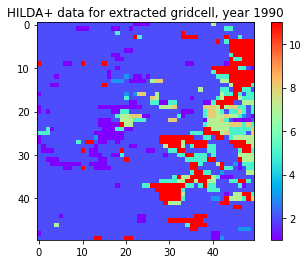

In [7]:
year=1990
plt.imshow(hilda_tr[year-hildayear0],cmap="rainbow")
plt.colorbar()
plt.title(f'HILDA+ data for extracted gridcell, year {year}')

## Calculate forest age

In natural forest in LPJ-GUESS, the forest age structure is determined by the return interval of patch destroying natural disturbances (fire is ignored here as it's more complex).The disturbance interval determines the probability of a patch destroying disturbance to occur, which would reset the forest age to 0. After a sufficient spin-up and with a sufficient number of patches, the natural forest age structure converges to a constant distribution depending only on the disturbance interval. We can simulate this via a simple Monte Carlo simulation where we simulate a number of patches that do nothing but getting older or being reset to age 0 by a disturbance occuring with a probability given by the disturbance interval. The following figure shows the age structure resulting from 4 different disturbance interval values.

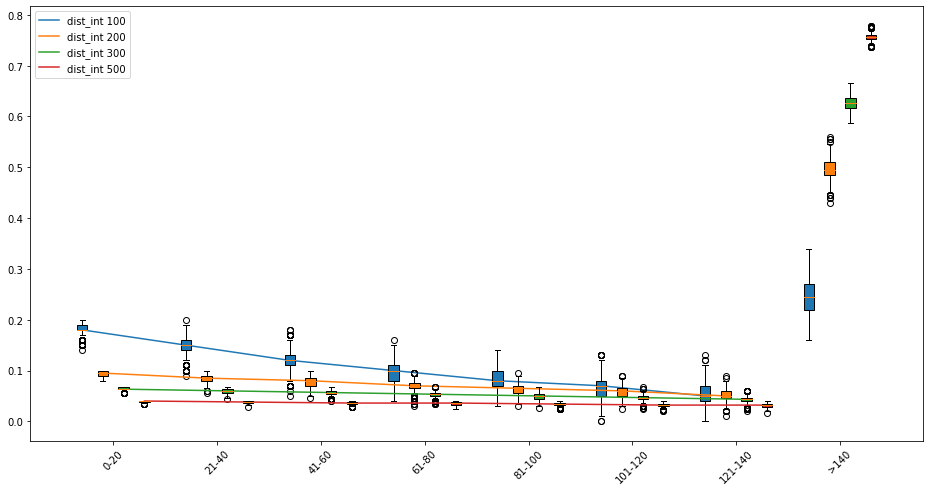

In [1]:
from IPython.display import Image
Image(filename='figs/distint.png') 

 `agestr_natural(dist_int)` in `age_init.py` performs such a simple Monte Carlo simulation and returns the age structure in fractions of the 8 age classes *0-20*, *21-40*, *41-60*, *61-80*, *81-100*, *101-120*, *121-140*, and *>140*.

Text(0.5, 0, 'age class')

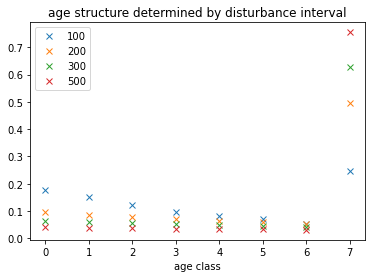

In [9]:
for distint in [100,200,300,500]:
    plt.plot(ag.agestr_natural(distint),"x",label=distint)
plt.legend()
plt.title("age structure determined by disturbance interval")
plt.xlabel("age class")

In managed forest, where natural disturbances are usually turned off, forest age structure is only forced by land use change and forest harvest. With HILDA+, which provides categorical landcover per 1km pixel per year, we can just count backwards how long existing forest pixel existed unchanged before the year we want to calculate the forest age for.`agestruct_coarsepixelhilda(hildadata1,year,hildayear0)` in `age_init.py` does that.

Text(0.5, 0, 'age class')

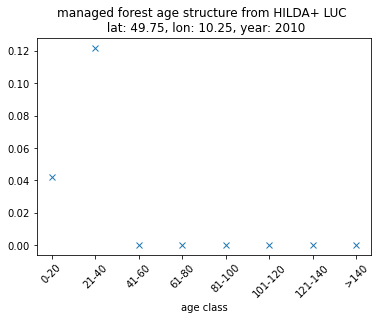

In [10]:
year=2010 ## year to calculate age for
### retrieve Hilda data for gridcell
h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
hilda_tr=st.hilda2lpjg_1slice(h1)
age_forest=ag.agestruct_coarsepixelhilda(hilda_tr,year,hildayear0)
plt.plot(np.histogram(age_forest,bins=np.arange(0,170,20))[0]/(hilda_tr.shape[1]*hilda_tr.shape[2]),"x")
plt.title(f"managed forest age structure from HILDA+ LUC \n lat: {lat}, lon: {lon}, year: {year}")
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.xlabel("age class")

`agestr_from_hildadata(slice1,dist_int,forestageyear,hildayear0)` in `age_init.py` returns the forest age structure in natural and managed forest for a given disturbance interval and HILDA+ data of a gridcell.

Text(0.5, 0, 'age class')

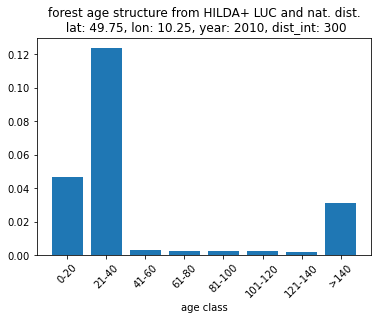

In [11]:
dist_int=300 ##disturbance interval
plt.bar(np.arange(8),ag.agestr_from_hildadata(hilda_tr,dist_int,year,hildayear0))
plt.title(f"forest age structure from HILDA+ LUC and nat. dist.\n lat: {lat}, lon: {lon}, year: {year}, dist_int: {dist_int}")
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.xlabel("age class")



Most recent version of LPJ-GUESS european_applications branch offers ageclass outputs for NATURAL and FOREST. Comparison showed that the age structure calculation from input data is pretty accurate (stochastic processes can't be precisely predicted) and  much less computation intensive than running LPJ-GUESS on order to get the age structure introduced by HILDA+.

## Forest age observation data
I am considering 2 different forest age datasets: *Global Forest Age Database* from Poulter et al. and a European higher-resolution forest structure data set by Pucher et al.. They are both gridded forest age products based on National Forest Inventory data, but differ in spatial resolution, age class resolution, coverage,... The definition of forest age is not entirely clear form the description papers and in an direct comparison of the forest age distributions they differ substantially.

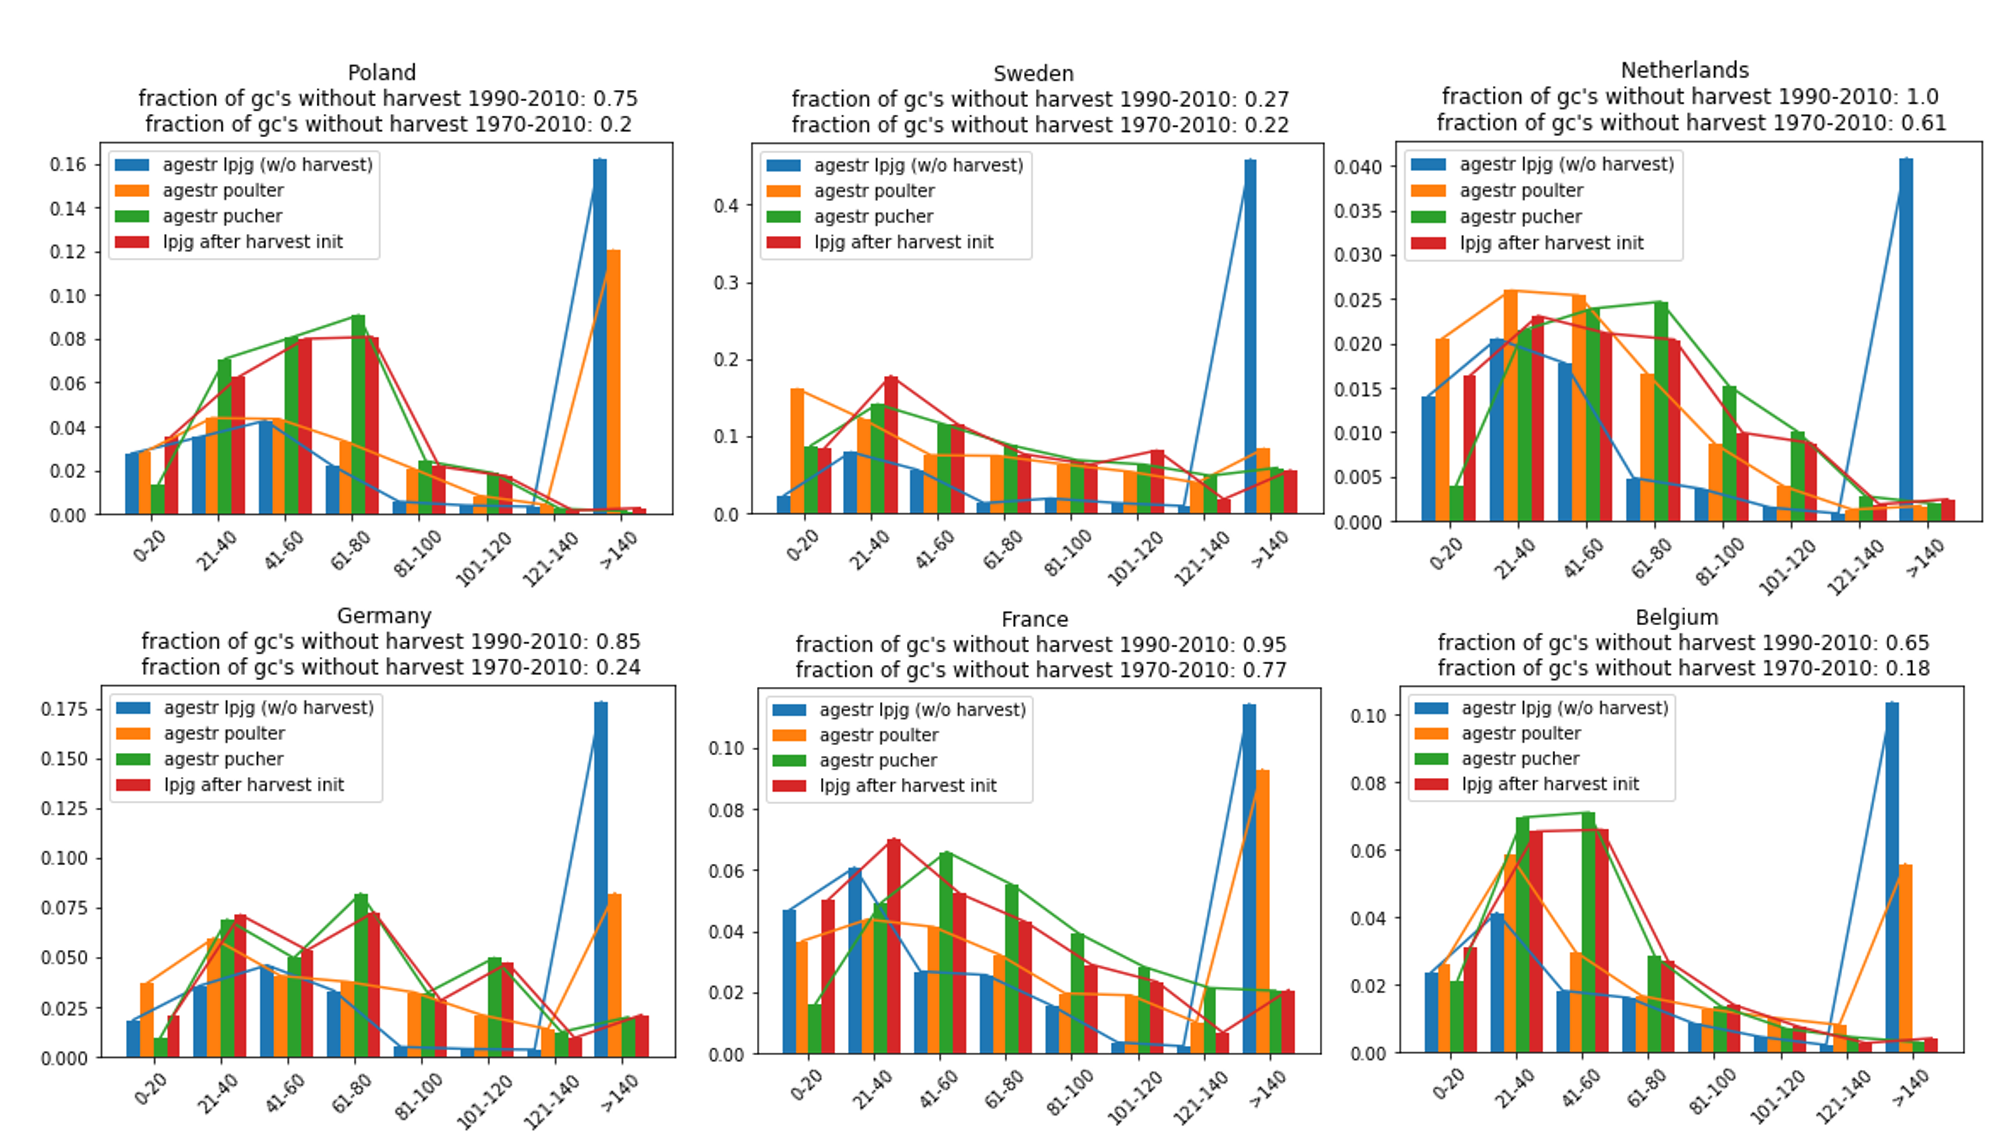

In [2]:
Image(filename='figs/agestructures.png') 

### Pucher
https://doi.org/10.3390/rs14020395


In [6]:
### LOAD PUCHER FOREST AGE DATA AND FUNCTIONS ###
### download Pucher et al. dataset from ftp server given in paper and adapt paths
###load Pucher geotiff files
pucher=np.array([rasterio.open(f'C:\\forest_age\\pucher_age\\Age\\agecl_{i+1}_perc.tif').read()[0] for i in range(8)])
lola_pucher=np.load("files/lonlat_pucher.npy") #I computed the coordinates of the geotiff files somewhere and saved them...

#function to return pucher data for any given latitude, longitude and resolution
def return_pucher_mask(lat,lon,res,lola_pucher):
    ### returns a mask (True/False values) on the Pucher grid for coordinates and gridcell size
    return (lola_pucher[0]>=lon-0.5*res)*(lola_pucher[0]<lon+0.5*res)*(lola_pucher[1]>=lat-0.5*res)*(lola_pucher[1]<lat+0.5*res)
### load forest cover (forest fraction in Hilda+ remapped to Pucher grid)
forest_cover=np.load("files/forest_cover_puchergrid.npy")

pucher_forestcoverscaled=np.ma.masked_equal(pucher,-9999)
for i in range(8):
    puchi=pucher[i]>0.
    pucher_forestcoverscaled[i,puchi]=pucher[i,puchi]*forest_cover[puchi]
    
def pucher_forestage_gc(lat,lon,res):
    return np.mean(pucher_forestcoverscaled[:,return_pucher_mask(lat,lon,res,lola_pucher)],axis=1)


### Poulter
https://doi.pangaea.de/10.1594/PANGAEA.897392

In [29]:
### LOAD POULTER FOREST AGE DATA AND FUNCTIONS ###
### adapt paths!
poulter=nc.Dataset('C:\\forest_age\\GFAD_V1-1\\GFAD_V1-1.nc')
plons=poulter["lon"][:].data
plats=poulter["lat"][:].data

def get_nearest_poulterdata(lon,lat,plons,plats):
    ### get Poulter et al. forest age distribution for given coordinates (nearest grid cell)
    poulteragecl= np.sum(poulter["age"][:,:,np.where(abs(plats-lat)==np.min(abs(plats-lat)))[0][0],np.where(abs(plons-lon)==np.min(abs(plons-lon)))[0][0]],axis=1)
    poulteragecl=[np.sum(poulteragecl[(i*2):((i+1)*2)]) for i in range(8)]
    if np.sum(poulteragecl)==0:
        return [0.,0.,0.,0.,0.,0.,0.,1.]
    else:
        return poulteragecl

## Calculate harvest based on differences between observed and current LPJG forest age structure
For every gridcell, LPJG and observed age class distributions are compared. Based on this difference, LUC/harvest events are introduced in order to minimize these differences.

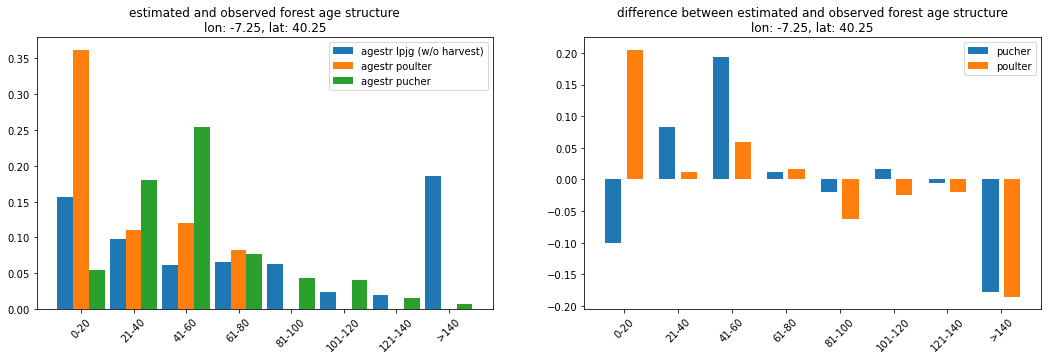

In [15]:
### random coordinates, re-run cell if no gridcell has no forest
lat=40.25+np.random.randint(30)*0.5
lon=-10.25++np.random.randint(30)*0.5
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=300 ##disturbance interval
### retrieve Hilda data for gridcell
h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
### translate HILDA+ codes to LPJG codes
hilda_tr=st.hilda2lpjg_1slice(h1)
### estimate age structure from Hilda+ data and disturbance interval
agestr_lpjg=ag.agestr_from_hildadata(hilda_tr,200,year,hildayear0)
### get Pucher age structure
age_puc=pucher_forestage_gc(lat,lon,res)
age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
### get Poulter age structure
age_pou=np.array(get_nearest_poulterdata(lon,lat,plons,plats))
age_pou=age_pou*np.sum(agestr_lpjg)/np.sum(age_pou) ### rescale age structure sum to hilda+ forest fraction

### plot
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.bar(np.arange(8),agestr_lpjg,width=0.3,label="agestr lpjg (w/o harvest)")
plt.bar(np.arange(8)+0.3,age_pou,width=0.3,label="agestr poulter")
plt.bar(np.arange(8)+0.6,age_puc,width=0.3,label="agestr pucher")
plt.xticks(np.arange(8)+0.3,["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.title(f"estimated and observed forest age structure\nlon: {lon}, lat: {lat}")
plt.legend()
plt.subplot(122)
plt.bar(np.arange(8)-0.2,age_puc-agestr_lpjg,width=0.3,label="pucher")
plt.bar(np.arange(8)+0.2,age_pou-agestr_lpjg,width=0.3,label="poulter")
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.title(f"difference between estimated and observed forest age structure\nlon: {lon}, lat: {lat}")
plt.legend()


Forest age is estimated as combined managed and natural forest age. In the example above, all forest categories from HILDA+ are interpreted as managed forest. That's why there is in many cases a relatively high fraction of 101-121 years old forest: HILDA+ starts at 1900 and a forest pixel that was classified as forest throughout the entire time series in HILDA+ is then interpreted as 110 years old managed forest in 2010. There are different approaches on how to split forest in natural/unmanaged and managed forest. In this forest age initialization procedure, the approach is to interpret every forest pixel that is forest from the beginning as natural forest and every forest pixel resulting from a LUC as managed forest. Later, additional LUC is introduced in order to comer closer to observed age structure so that in the we split the forest in managed and unmanged based on how much LUC happened in the past according to HILDA+ and how different the age structure is from observed age structure.

The Hilda+ categories *unmanaged grass / shrubland* and *sparse / no vegetation* are translated to LGJ-GUESS category *NATURAL* and then also included in the forest age calculation. In order to calculate a realistic age structure, we introduce an extra category (code 0) for *shrubs/grassland/otherland* that we can put back to *NATURAL* at the end of the procedure but ignore it during the age initialization process.

The function `hilda2lpjg_1slice_shrub0()` in`age_init.py` manages translating HILDA+ category codes into LPJG codes as `hilda2lpjg_1slice()` but translates *shrubs/grassland/otherland* to code 0 instead of 5. `shrubs2nat()` translates code 0 back to 5 (*NATURAL*). 

`initial_nat_forest_split()` manages the initial forest split between natural and managed forest as described above.

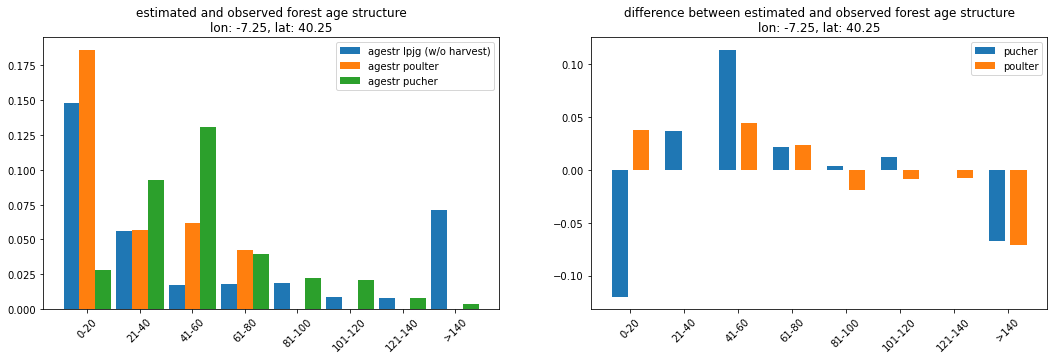

In [16]:
### translate HILDA+ codes to LPJG codes
hilda_tr=ag.hilda2lpjg_1slice_shrub0(h1)
hilda_nf=ag.initial_nat_forest_split(hilda_tr)
### estimate age structure from Hilda+ data and disturbance interval
agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,200,year,hildayear0)
### get Pucher age structure
age_puc=pucher_forestage_gc(lat,lon,res)
age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
### get Poulter age structure
age_pou=np.array(get_nearest_poulterdata(lon,lat,plons,plats))
age_pou=age_pou*np.sum(agestr_lpjg)/np.sum(age_pou) ### rescale age structure sum to hilda+ forest fraction

### plot
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.bar(np.arange(8),agestr_lpjg,width=0.3,label="agestr lpjg (w/o harvest)")
plt.bar(np.arange(8)+0.3,age_pou,width=0.3,label="agestr poulter")
plt.bar(np.arange(8)+0.6,age_puc,width=0.3,label="agestr pucher")
plt.xticks(np.arange(8)+0.3,["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.title(f"estimated and observed forest age structure\nlon: {lon}, lat: {lat}")
plt.legend()
plt.subplot(122)
plt.bar(np.arange(8)-0.2,age_puc-agestr_lpjg,width=0.3,label="pucher")
plt.bar(np.arange(8)+0.2,age_pou-agestr_lpjg,width=0.3,label="poulter")
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.title(f"difference between estimated and observed forest age structure\nlon: {lon}, lat: {lat}")
plt.legend()

From this point on I will continue with the Pucher et al. dataset as forest age observation. The procedure is exactly the same for the Poulter et al. data or any other forest age dataset. 

Based on the difference between the observed forest age structure and the one derived from HILDA+, we calculate harvest amounts per age class. Harvest is here always realized as LUC from *NATURAL* to *FOREST*. The difference in old growth forest fractions between estimated and observed determines the maximum harvest amount per gridcell: We can only introduce LUC from *NATURAL* to *FOREST* if there is too much natural forest according to the forest age data.

`calc_harvest_experimental()` in `age_init.py` calculates the harvest fractions per ageclass per grid cell:




In [40]:
def calc_harvest_experimental(agestr_lpjg,forestage_obs,forestageyear,natfrac,hildayear0):
    diff=agestr_lpjg-forestage_obs   ### calculate difference between lpjg and obs age structure
    harvest=np.zeros_like(diff)
    harvest_amount=diff[-1]/natfrac[-1]   ### maximum harvest amount to distribute is the difference in old growth forest divided by the fraction of old growth in natural forest
    harv_amou0=harvest_amount
    ran=np.arange(7)       # 7 age classes below old grwoth to be randomly shuffled
    np.random.shuffle(ran) # to randomly distribute the maximum harvest amount
    for k in ran:       ### calculate the harvest fractions for each of the 7 age classes
        if harvest_amount>0.:
            if diff[k]<0.:
                harv_here=np.min((harvest_amount,-1*diff[k] + (harv_amou0)*natfrac[k]))  ### harvest per age class is the difference per ageclass + the fraction of natural in that ageclass that is lost
                harvest[k]=harv_here
                harvest_amount-=harv_here
    harvest_years=np.zeros(forestageyear-hildayear0) 
    for k in range(7): ### place harvest at random years in resp. 20-years period
        kyear=-k*20-np.random.randint(20)  
        if kyear < -len(harvest_years):
            kyear=0
        harvest_years[kyear]+=harvest[k]
    return harvest_years  

```
def calc_harvest_experimental(agestr_lpjg,forestage_obs,forestageyear,natfrac,hildayear0):
```
It takes the estimated age structure, the observed age structure, the year to initialize, the age structure of natural forest, and the first year of the analized hilda+ array as arguments.
```
    harvest_amount=diff[-1]/natfrac[-1] 
```
The maximum harvest amount per gridcell is the difference in old growth forest divided by the fraction of old growth forest in natural forest
```
    ran=np.arange(7)       # 7 age classes below old grwoth to be randomly shuffled
    np.random.shuffle(ran) # to randomly distribute the maximum harvest amount
```
We're creating a run variable to run through the age classes and shuffle it randomly in order to distribute the maximum harvest amount randomly.
```
                harv_here=np.min((harvest_amount,-1*diff[k] + (harv_amou0)*natfrac[k])) 
                harvest[k]=harv_here
                harvest_amount-=harv_here
```
We can only bring the fraction of an age class closer to observations if the fraction of that age class given by HILDA+ LUC and natural disturbances is lower than the observed one. The ideal harvest amount in this case would be 

$$
H_k=\Delta_k+H_s*N_k
$$


$$
H_s=\frac{\Delta_{oldgr}}{N_{oldgr}}
$$
where $k$ is the age class, $H_k$ is the harvest amount of age class $k$, $\Delta_k$ is the difference in age class $k$ fractions between estimated and observed, $H_s$ is the overall available harvest amount per gridcell, $N$ is the natural forest age structure.
The actual harvest amount per age class is the minimum of this calculated ideal harvest amount and the harvest amount left to distribute in that gridcell.

This harvest amount per age class is then turned into harvest events at random years in the corresponding time period. 

(1900.0, 2030.0)

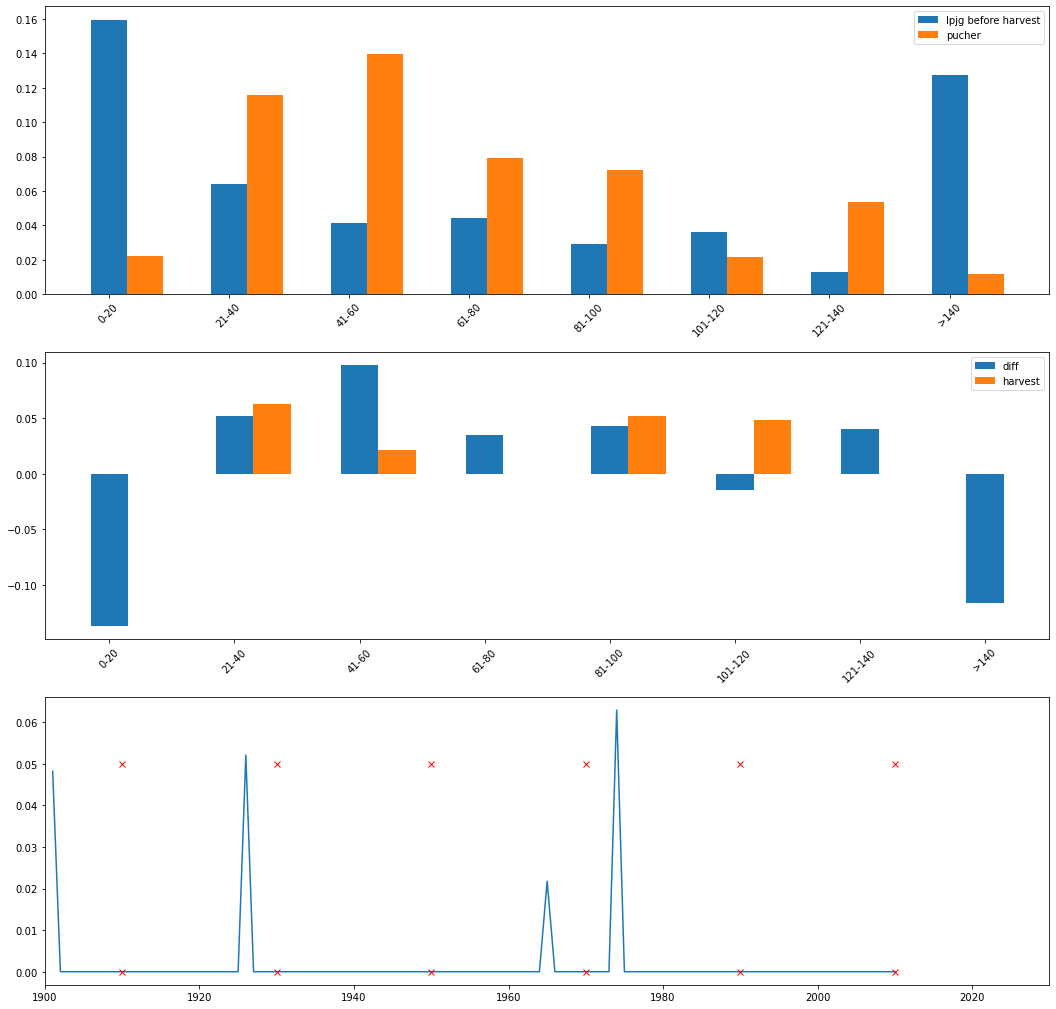

In [49]:
### random coordinates
lon=2.25
lat=47.25
### uncomment the following 2 lines to have really random coordinates (not all coordinates work well, re-run cell to go through random gridcells)
#lat=40.25+np.random.randint(30)*0.5
#lon=-10.25++np.random.randint(30)*0.5
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=300 ##disturbance interval
### retrieve Hilda data for gridcell
h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
### translate HILDA+ codes to LPJG codes
hilda_tr=ag.hilda2lpjg_1slice_shrub0(h1)
hilda_nf=ag.initial_nat_forest_split(hilda_tr)
### estimate age structure from Hilda+ data and disturbance interval
agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,200,year,hildayear0)
### get Pucher age structure
age_puc=pucher_forestage_gc(lat,lon,res)
age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
### get natural age structure from disturbance interval
natfrac=ag.agestr_natural(dist_int)
### calculate harvest
harvest=calc_harvest_experimental(agestr_lpjg,age_puc,2010,natfrac,hildayear0)


plt.figure(figsize=(18,18))
plt.subplot(311)
plt.bar(np.arange(8),agestr_lpjg,width=0.3,label="lpjg before harvest")
plt.bar(np.arange(8)+0.3,age_puc,width=0.3,label="pucher")
plt.legend()
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)

plt.subplot(312)
plt.bar(np.arange(8),age_puc-agestr_lpjg,width=0.3,label="diff")
harvbars=[np.sum(harvest[((i+1)*-20-1):((i)*-20-1)]) for i in range(7)]
plt.bar(np.arange(7)+0.3,harvbars,width=0.3,label="harvest")
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.legend()
plt.subplot(313)
plt.plot(np.arange(len(harvest))+hildayear0+1,harvest)
plt.plot([year - i*20 for i in range(6)],[0.,0.,0.,0.,0.,0.],"rx")
plt.plot([year - i*20 for i in range(6)],[0.05,0.05,0.05,0.05,0.05,0.05],"rx")
plt.xlim(1900,2030)



As the harvest calculation is partly randomized, the above figure might look different every time you execute it. The bar plot of the harvest amount in the middle is not super accurate, it fails in some cases to assign harvest amount to the right age class. I just didn't put more effort into it as it's only about the plot function for demonstration purpose. The plot at the bottom is what the function calculated as harvest

Function `apply_harvest(slice1,harv_years,allforestslice,forestageyear,hildayear0)` in `age_init.py` handles applying the the calculated harvest events and turns them into LUC events. See below the same plot as above, but with application of harvest to the HILDA+ array and then estimation of its age structure after harvest.

(1900.0, 2030.0)

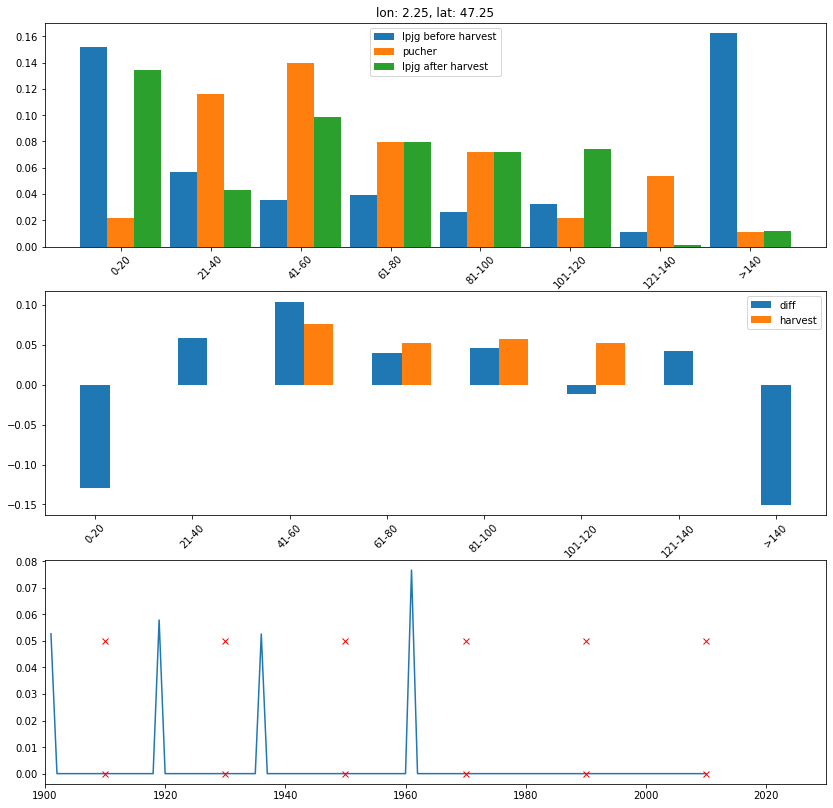

In [53]:
### retrieve Hilda data for gridcell
h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
### translate HILDA+ codes to LPJG codes
hilda_tr=ag.hilda2lpjg_1slice_shrub0(h1)
hilda_nf=ag.initial_nat_forest_split(hilda_tr)
### estimate age structure from Hilda+ data and disturbance interval
agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,dist_int,year,hildayear0)
### get Pucher age structure
age_puc=pucher_forestage_gc(lat,lon,res)
age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
### get natural age structure from disturbance interval
natfrac=ag.agestr_natural(dist_int)
### calculate harvest
harvest=calc_harvest_experimental(agestr_lpjg,age_puc,2010,natfrac,hildayear0)

### apply harvest
hilda_harv=ag.apply_harvest(hilda_nf,harvest,ag.allforest(hilda_nf),year,hildayear0)
agestr_lpjg2=ag.agestr_from_hildadata(hilda_harv,dist_int,year,hildayear0)


plt.figure(figsize=(14,14))
plt.subplot(311)
plt.bar(np.arange(8)-0.3,agestr_lpjg,width=0.3,label="lpjg before harvest")
plt.bar(np.arange(8),age_puc,width=0.3,label="pucher")
plt.bar(np.arange(8)+0.3,agestr_lpjg2,width=0.3,label="lpjg after harvest")
plt.title(f'lon: {lon}, lat: {lat}')
plt.legend()
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)

plt.subplot(312)
plt.bar(np.arange(8),age_puc-agestr_lpjg,width=0.3,label="diff")
harvbars=[np.sum(harvest[((i+1)*-20-1):((i)*-20-1)]) for i in range(7)]
plt.bar(np.arange(7)+0.3,harvbars,width=0.3,label="harvest")
plt.xticks(np.arange(8),["0-20","21-40","41-60","61-80","81-100","101-120","121-140",">140"],rotation=45)
plt.legend()
plt.subplot(313)
plt.plot(np.arange(len(harvest))+hildayear0+1,harvest)
plt.plot([year - i*20 for i in range(6)],[0.,0.,0.,0.,0.,0.],"rx")
plt.plot([year - i*20 for i in range(6)],[0.05,0.05,0.05,0.05,0.05,0.05],"rx")
plt.xlim(1900,2030)



Below is a plot of the landcover fractions of the gridcell used above before and after forest age initialization:

Text(0.5, 0.98, '\n\nlon: 2.25, lat: 47.25')

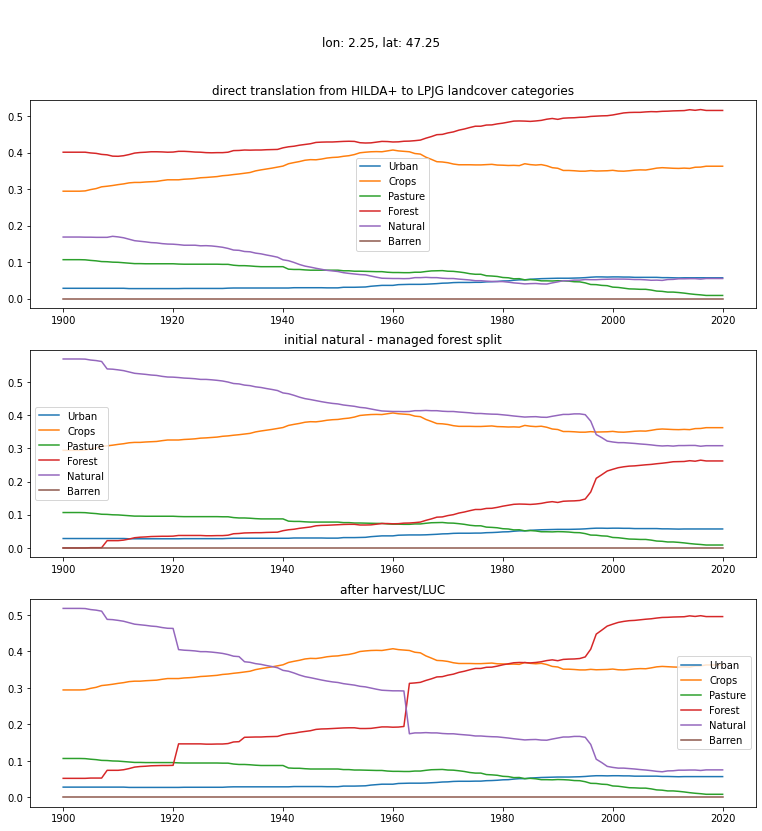

In [51]:
plt.figure(figsize=(13,13))
plt.subplot(311)
hilda_array=ag.shrubs2nat(hilda_tr)
landcovers=["None","Urban","Crops","Pasture","Forest","Natural","Barren","FOREST"]
for i in range(1,7):
    if i ==4:
        plt.plot(np.arange(hilda_array.shape[0])+hildayear0,np.mean(hilda_array>=7,axis=(1,2)),label=landcovers[i])
    else:
        plt.plot(np.arange(hilda_array.shape[0])+hildayear0,np.mean(hilda_array==i,axis=(1,2)),label=landcovers[i])
plt.legend()
plt.title("direct translation from HILDA+ to LPJG landcover categories")
plt.subplot(312)
hilda_array=ag.shrubs2nat(hilda_nf)
landcovers=["None","Urban","Crops","Pasture","Forest","Natural","Barren","FOREST"]
for i in range(1,7):
    if i ==4:
        plt.plot(np.arange(hilda_array.shape[0])+hildayear0,np.mean(hilda_array>=7,axis=(1,2)),label=landcovers[i])
    else:
        plt.plot(np.arange(hilda_array.shape[0])+hildayear0,np.mean(hilda_array==i,axis=(1,2)),label=landcovers[i])
plt.legend()
plt.title("initial natural - managed forest split")
plt.subplot(313)
hilda_array=ag.shrubs2nat(hilda_harv)
landcovers=["None","Urban","Crops","Pasture","Forest","Natural","Barren","FOREST"]
for i in range(1,7):
    if i ==4:
        plt.plot(np.arange(hilda_array.shape[0])+hildayear0,np.mean(hilda_array>=7,axis=(1,2)),label=landcovers[i])
    else:
        plt.plot(np.arange(hilda_array.shape[0])+hildayear0,np.mean(hilda_array==i,axis=(1,2)),label=landcovers[i])
plt.legend()
plt.title("after harvest/LUC")
plt.suptitle(f'\n\nlon: {lon}, lat: {lat}')

## Write to LPJG land use input file

A few examples how to create LPJ-GUESS land use input files from forest age initialization.
Land use input tables are created as pandas Dataframes and can be written to files with `write_output_txt(df1,filename)` in `gross_st_matrix_hildaplus.py`.


In [5]:
### EXAMPLE GRID LIST ###
grid_eur=[
[20.25  , 67.75 ]  ,
[-2.75  , 55.25   ] ,  
[10.25  , 53.75    ] ,  
[23.75  , 52.75  ] ,
[2.25   , 48.25  ]  ,         
[7.25   , 46.25  ]   ,      
[9.25   , 45.75  ]    ,     
[27.75  , 43.75  ]     ,
[-7.75  , 43.25  ]    ,
[17.25  , 40.75  ] 
]

## Example: Net land use file
HILDA+ as basis, age initialization with Pucher et al. data and a disturbance interval of 300 years

In [105]:
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=300 ##disturbance interval
natfrac=ag.agestr_natural(dist_int)
hildayear0=1900
net_file=[]

def make_net_lu_1gridcell(hildadata,lon,lat,year0):
    ### function to write net lu file entry for one gridcell
    net_df=pd.DataFrame({"Lon":np.repeat(lon,hildadata.shape[0]),
                         "Lat":np.repeat(lat,hildadata.shape[0]),
                         "Year":np.arange(hildadata.shape[0])+year0})
    landcovers=["None","URBAN","CROPLAND","PASTURE","FOREST","NATURAL","BARREN"]
    for i in range(1,7):
        if i ==4:
            net_df[landcovers[i]]=np.mean(hildadata>=7,axis=(1,2))
        else:
            net_df[landcovers[i]]=np.mean(hildadata==i,axis=(1,2))
    return net_df

for lon, lat in grid_eur:
    ### retrieve Hilda data for gridcell
    h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
    ### translate HILDA+ codes to LPJG codes
    hilda_tr=ag.hilda2lpjg_1slice_shrub0(h1)    ### keeping shrubs separate
    hilda_nf=ag.initial_nat_forest_split(hilda_tr)
    ### estimate age structure from Hilda+ data and disturbance interval
    agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,dist_int,year,hildayear0)
    ### get Pucher age structure
    age_puc=pucher_forestage_gc(lat,lon,res)
    age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
    ### calculate harvest
    harvest=ag.calc_harvest_experimental(agestr_lpjg,age_puc,year,natfrac,hildayear0)
    ### apply harvest
    hilda_harv=ag.shrubs2nat(ag.apply_harvest(hilda_nf,harvest,ag.allforest(hilda_tr),year,hildayear0))
    net_file.append(make_net_lu_1gridcell(hilda_harv,lon,lat,hildayear0))
    print(lon,lat)

net_file=pd.concat(net_file)
net_file
### to write file: uncomment following line!
#st.write_output_txt(net_file,"net_lu_file.txt")

20.25 67.75
-2.75 55.25
10.25 53.75
23.75 52.75
2.25 48.25
7.25 46.25
9.25 45.75
27.75 43.75
-7.75 43.25
17.25 40.75


Lon    Lat  Year   URBAN  CROPLAND  PASTURE  FOREST  NATURAL  BARREN
0    20.25  67.75  1900  0.0000    0.0000   0.0352  0.0000   0.9320  0.0328
1    20.25  67.75  1901  0.0000    0.0000   0.0352  0.0000   0.9320  0.0328
2    20.25  67.75  1902  0.0000    0.0000   0.0352  0.0000   0.9320  0.0328
3    20.25  67.75  1903  0.0000    0.0000   0.0352  0.0000   0.9320  0.0328
4    20.25  67.75  1904  0.0000    0.0000   0.0352  0.0000   0.9320  0.0328
..     ...    ...   ...     ...       ...      ...     ...      ...     ...
116  17.25  40.75  2016  0.0656    0.4308   0.0212  0.0460   0.3236  0.1128
117  17.25  40.75  2017  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128
118  17.25  40.75  2018  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128
119  17.25  40.75  2019  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128
120  17.25  40.75  2020  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128

[1210 rows x 9 columns]

## Example: Forest age initialization without HILDA+
Instead of Hilda+ data, we just create arrays with 100% NATURAL for every gridcell

In [9]:
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=300 ##disturbance interval
natfrac=ag.agestr_natural(dist_int)
hildayear0=1900
net_file=[]

def make_net_lu_1gridcell(hildadata,lon,lat,year0):
    ### function to write net lu file entry for one gridcell
    net_df=pd.DataFrame({"Lon":np.repeat(lon,hildadata.shape[0]),
                         "Lat":np.repeat(lat,hildadata.shape[0]),
                         "Year":np.arange(hildadata.shape[0])+year0})
    landcovers=["None","URBAN","CROPLAND","PASTURE","FOREST","NATURAL","BARREN"]
    for i in range(4,6):
        if i ==4:
            net_df[landcovers[i]]=np.mean(hildadata>=7,axis=(1,2))
        else:
            net_df[landcovers[i]]=np.mean(hildadata==i,axis=(1,2))
    return net_df

for lon, lat in grid_eur:
    hilda_nf=np.reshape(np.repeat(5,121*25*25),(121,25,25)) ### dummy array that mimics a Hilda+ array but is only NATURAL (code 5)
    ###                                                     ### 25*25 pixels because harvest is applied to single pixels -> number of pixels determines resolution 
    ### estimate age structure from Hilda+ data and disturbance interval
    agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,dist_int,year,hildayear0)
    ### get Pucher age structure
    age_puc=pucher_forestage_gc(lat,lon,res)
    age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
    ### calculate harvest
    harvest=ag.calc_harvest_experimental(agestr_lpjg,age_puc,year,natfrac,hildayear0)
    ### apply harvest
    hilda_harv=ag.shrubs2nat(ag.apply_harvest(hilda_nf,harvest,ag.allforest(hilda_tr),year,hildayear0))
    net_file.append(make_net_lu_1gridcell(hilda_harv,lon,lat,hildayear0))
    print(lon,lat)

net_file=pd.concat(net_file)
net_file
### to write file: uncomment following line!
#st.write_output_txt(net_file,"net_lu_file.txt")

20.25 67.75
-2.75 55.25
10.25 53.75
23.75 52.75
2.25 48.25
7.25 46.25
9.25 45.75
27.75 43.75
-7.75 43.25
17.25 40.75


Lon    Lat  Year  FOREST  NATURAL
0    20.25  67.75  1900  0.0416   0.9584
1    20.25  67.75  1901  0.0416   0.9584
2    20.25  67.75  1902  0.0416   0.9584
3    20.25  67.75  1903  0.0416   0.9584
4    20.25  67.75  1904  0.0416   0.9584
..     ...    ...   ...     ...      ...
116  17.25  40.75  2016  0.9520   0.0480
117  17.25  40.75  2017  0.9520   0.0480
118  17.25  40.75  2018  0.9520   0.0480
119  17.25  40.75  2019  0.9520   0.0480
120  17.25  40.75  2020  0.9520   0.0480

[1210 rows x 5 columns]

## Example: extend land use input back to 1870
like first example, function `extend_hildaslice()` from `age_init.py` extends hilda+ array back to 1870 after initial natural/managed forest split (extension by keeping BARREN constant, all other land covers are NATURAL before 1900).

In [71]:
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=300 ##disturbance interval
natfrac=ag.agestr_natural(dist_int)
hildayear0=1870
net_file=[]

def make_net_lu_1gridcell(hildadata,lon,lat,year0):
    ### function to write net lu file entry for one gridcell
    net_df=pd.DataFrame({"Lon":np.repeat(lon,hildadata.shape[0]),
                         "Lat":np.repeat(lat,hildadata.shape[0]),
                         "Year":np.arange(hildadata.shape[0])+year0})
    landcovers=["None","URBAN","CROPLAND","PASTURE","FOREST","NATURAL","BARREN"]
    for i in range(1,7):
        if i ==4:
            net_df[landcovers[i]]=np.mean(hildadata>=7,axis=(1,2))
        else:
            net_df[landcovers[i]]=np.mean(hildadata==i,axis=(1,2))
    return net_df

for lon, lat in grid_eur:
    ### retrieve Hilda data for gridcell
    h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
    ### translate HILDA+ codes to LPJG codes
    hilda_tr=ag.hilda2lpjg_1slice_shrub0(h1)    ### keeping shrubs separate
    hilda_nf=ag.extend_hildaslice(ag.initial_nat_forest_split(hilda_tr),30)  ##
    ### estimate age structure from Hilda+ data and disturbance interval
    agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,dist_int,year,hildayear0)
    ### get Pucher age structure
    age_puc=pucher_forestage_gc(lat,lon,res)
    age_puc=age_puc*np.sum(agestr_lpjg)/np.sum(age_puc) ### rescale age structure sum to hilda+ forest fraction
    ### calculate harvest
    harvest=ag.calc_harvest_experimental(agestr_lpjg,age_puc,year,natfrac,hildayear0)
    ### apply harvest
    hilda_harv=ag.shrubs2nat(ag.apply_harvest(hilda_nf,harvest,ag.allforest(hilda_tr),year,hildayear0))
    net_file.append(make_net_lu_1gridcell(hilda_harv,lon,lat,hildayear0))
    print(lon,lat)

pd.concat(net_file)
### to write file: uncomment following line!
#st.write_output_txt(net_file,"net_lu_file.txt")

20.25 67.75
-2.75 55.25
10.25 53.75
23.75 52.75
2.25 48.25
7.25 46.25
9.25 45.75
27.75 43.75
-7.75 43.25
17.25 40.75


Lon    Lat  Year   URBAN  CROPLAND  PASTURE  FOREST  NATURAL  BARREN
0    20.25  67.75  1870  0.0000    0.0000   0.0000  0.0000   0.9672  0.0328
1    20.25  67.75  1871  0.0000    0.0000   0.0000  0.0000   0.9672  0.0328
2    20.25  67.75  1872  0.0000    0.0000   0.0000  0.0000   0.9672  0.0328
3    20.25  67.75  1873  0.0000    0.0000   0.0000  0.0000   0.9672  0.0328
4    20.25  67.75  1874  0.0000    0.0000   0.0000  0.0000   0.9672  0.0328
..     ...    ...   ...     ...       ...      ...     ...      ...     ...
146  17.25  40.75  2016  0.0656    0.4308   0.0212  0.0460   0.3236  0.1128
147  17.25  40.75  2017  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128
148  17.25  40.75  2018  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128
149  17.25  40.75  2019  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128
150  17.25  40.75  2020  0.0660    0.4352   0.0176  0.0444   0.3240  0.1128

[1510 rows x 9 columns]

If we want to have different stand types in more than one landcover, we need to provide a gross stand type transition matrix, a net land use input file and, if we are having multipe cropland and forest stand types, a *lu_crop* and a *lu_forest* file. As these files have to be 100% consistent, we create the gross transitions file first and derive all other files from it. `gross_st_matrix_hildaplus.py` contains some functions to handle this.
## Example: gross stand type transition matrix, different Forest stand types from Hilda+, crops MIRCA2000, no forest age initialization


In this example, we split the managed forest into 5 managed forest stand types (*Fpnv*, *Fne*, *Fnd*, *Fbe*, *Fbd*) based on HILDA+, crop standtype fractions are read from a file that contains MIRCA2000 crop st fractions for every gridcell. We just skip the forest age initialization part. In this case, all HILDA+ forest is put to *FOREST*, shrubs, unmanaged grass and otehr land are *NATURAL*.

In [20]:
res=0.5 ##resolution
hildayear0=1900
gross_tables=[]
net_tables=[]
cropstfracs=pd.read_pickle("files/mirca2000.pickle")

for lon, lat in grid_eur:
    ### retrieve Hilda data for gridcell
    h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
    ### translate HILDA+ codes to LPJG codes
    hilda_tr=st.hilda2lpjg_1slice(h1)    ### keeping shrubs separate
    ### create gross st transition matrix for current gridcell
    gross=st.create_grosstrans_table_mirca(hilda_tr,hildayear0,lon,lat,cropstfracs)
    ### derive net st table from gross transitions
    net_tables.append(st.create_net_table_mirca(hilda_tr,hildayear0,lon,lat,gross,cropstfracs))
    gross_tables.append(gross)
    print(lon,lat)


20.25 67.75
-2.75 55.25
10.25 53.75
23.75 52.75
2.25 48.25
7.25 46.25
9.25 45.75
27.75 43.75
-7.75 43.25
17.25 40.75


In [21]:
###################################################
####### WRITE LPJ-GUESS LAND USE INPUT FILES ######
###################################################
filenameext="example_Hilda_Mirca2000_gross"
gt=pd.concat(gross_tables)  ### concatenate gross tables for single gridcells to one table
nt=pd.concat(net_tables)    ### concatenate net fractions tables
st.write_output_txt(gt,f"gross_st_trans_{filenameext}.txt")  ### write file_grossSTC
st.write_output_txt(nt,f"net_st_frac_{filenameext}.txt") ### this file is not needed by LPJ-GUESS as input, but might help 
##                                                   to check if gross transitions and net farctions are really consistent 
net_lu=st.make_netlandcover_mirca(nt,cropstfracs)
st.write_output_txt(net_lu,f"net_lu_{filenameext}.txt")
net_luf=st.make_luforest(nt)
st.write_output_txt(net_luf,f"lu_forest_{filenameext}.txt")
net_luc=st.make_lucrop_mirca(nt,cropstfracs)
st.write_output_txt(net_luc,f"lu_crop_{filenameext}.txt")

## Example: gross stand type matrix, forest age init based on Poulter forest age, crops MIRCA2000

In [31]:
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=1000 ##disturbance interval
natfrac=ag.agestr_natural(dist_int)
hildayear0=1870
gross_tables=[]
net_tables=[]
cropstfracs=pd.read_pickle("files/mirca2000.pickle")

for lon, lat in grid_eur:
    ### retrieve Hilda data for gridcell
    h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
    ### translate HILDA+ codes to LPJG codes
    hilda_tr=ag.hilda2lpjg_1slice_shrub0(h1)    ### keeping shrubs separate
    hilda_nf=ag.extend_hildaslice(ag.initial_nat_forest_split(hilda_tr),30)  ##
    ### estimate age structure from Hilda+ data and disturbance interval
    agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,dist_int,year,hildayear0)
    ### get age structure observation
    age_obs=np.array(get_nearest_poulterdata(lon,lat,plons,plats))
    age_obs=age_obs*np.sum(agestr_lpjg)/np.sum(age_obs) ### rescale age structure sum to hilda+ forest fraction
    ### calculate harvest
    harvest=ag.calc_harvest_experimental(agestr_lpjg,age_obs,year,natfrac,hildayear0)
    ### apply harvest
    hilda_harv=ag.shrubs2nat(ag.apply_harvest(hilda_nf,harvest,ag.allforest(hilda_tr),year,hildayear0))
    ### create gross st transition matrix for current gridcell
    gross=st.create_grosstrans_table_mirca(hilda_harv,hildayear0,lon,lat,cropstfracs)
    ### derive net st table from gross transitions
    net_tables.append(st.create_net_table_mirca(hilda_harv,hildayear0,lon,lat,gross,cropstfracs))
    gross_tables.append(gross)
    print(lon,lat)


20.25 67.75
-2.75 55.25
10.25 53.75
23.75 52.75
2.25 48.25
7.25 46.25
9.25 45.75
27.75 43.75
-7.75 43.25
17.25 40.75


In [32]:
###################################################
####### WRITE LPJ-GUESS LAND USE INPUT FILES ######
###################################################
filenameext="example_Hilda_Mirca2000_gross_Poulter_ageinit"
gt=pd.concat(gross_tables)  ### concatenate gross tables for single gridcells to one table
nt=pd.concat(net_tables)    ### concatenate net fractions tables
st.write_output_txt(gt,f"gross_st_trans_{filenameext}.txt")  ### write file_grossSTC
st.write_output_txt(nt,f"net_st_frac_{filenameext}.txt") ### this file is not needed by LPJ-GUESS as input, but might help 
##                                                   to check if gross transitions and net farctions are really consistent 
net_lu=st.make_netlandcover_mirca(nt,cropstfracs)
st.write_output_txt(net_lu,f"net_lu_{filenameext}.txt")
net_luf=st.make_luforest(nt)
st.write_output_txt(net_luf,f"lu_forest_{filenameext}.txt")
net_luc=st.make_lucrop_mirca(nt,cropstfracs)
st.write_output_txt(net_luc,f"lu_crop_{filenameext}.txt")

## Example: gross stand type transition matrix, age initialization based on Pucher et al. data, crops based on MIRCA2000, Forest based on Brus et al. forest composition
Here we neglect the HILDA+ classification into different forest types, just take HILDA+ for classification in urban, cropland, pasture, forest, and barren. From the Brus et. al tree species composition (http://dx.doi.org/10.1007/s10342-011-0513-5), I derived 10 forest stand types covering the most common tree species and their fractions per gridcell, see: https://codebase.helmholtz.cloud/martin.wittenbrink/brustreespecies


In [106]:
res=0.5 ##resolution
year=2010 ## year to calculate age for
dist_int=1000 ##disturbance interval
natfrac=ag.agestr_natural(dist_int)
hildayear0=1870
gross_tables=[]
net_tables=[]
### import crop and forest stnadtype fractions
cropstfracs=pd.read_pickle("files/mirca2000.pickle")
foreststfracs=pd.read_csv("files/Brus_STfracs.txt",delim_whitespace=True)
### round crop crop and forest standtype fractions to 2 decimals (if we multiply already small gross transitions 
### with multiple other datasets, multiplying machine precision errors might cause problems. limiting the data to 2 decimals helps.)
cropstfracs=st.round_dataframe(cropstfracs,2)
foreststfracs=st.round_dataframe(foreststfracs,2)
for lon, lat in grid_eur:
    ### retrieve Hilda data for gridcell
    h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
    ### translate HILDA+ codes to LPJG codes
    hilda_tr=ag.allforest2Fpnv(st.hilda2lpjg_1slice_shrub0(h1))    ### keeping shrubs separate, 
    hilda_nf=ag.extend_hildaslice(ag.initial_nat_forest_split(hilda_tr),30)  ##
    ### estimate age structure from Hilda+ data and disturbance interval
    agestr_lpjg=ag.agestr_from_hildadata(hilda_nf,dist_int,year,hildayear0)
    ### get age structure observation
    age_obs=pucher_forestage_gc(lat,lon,res)
    age_obs=age_obs*np.sum(agestr_lpjg)/np.sum(age_obs) ### rescale age structure sum to hilda+ forest fraction
    ### calculate harvest
    harvest=ag.calc_harvest_experimental(agestr_lpjg,age_obs,year,natfrac,hildayear0)
    ### apply harvest
    hilda_harv=ag.shrubs2nat(ag.apply_harvest(hilda_nf,harvest,ag.allforest(hilda_nf),year,hildayear0))
    ### create gross st transition matrix for current gridcell
    gross,net_firstyear = st.create_grosstrans_n_netst_table_mirca_forestfracs(hilda_harv,hildayear0,lon,lat,cropstfracs,foreststfracs)
    net_tables.append(st.create_net_table_auto(gross,net_firstyear))
    gross_tables.append(gross)
    print(lon,lat)


20.25 67.75
-2.75 55.25
10.25 53.75
23.75 52.75
2.25 48.25
7.25 46.25
9.25 45.75
27.75 43.75
-7.75 43.25
17.25 40.75


In [107]:
###################################################
####### WRITE LPJ-GUESS LAND USE INPUT FILES ######
###################################################
filenameext="example_Hilda_Mirca2000_Brus_Pucher_ageinit"
gt=pd.concat(gross_tables)  ### concatenate gross tables for single gridcells to one table
nt=pd.concat(net_tables)    ### concatenate net fractions tables
#st.write_output_txt(gt,f"gross_st_trans_{filenameext}.txt")  ### write file_grossSTC
#st.write_output_txt(nt,f"net_st_frac_{filenameext}.txt") ### this file is not needed by LPJ-GUESS as input, but might help 
##                                                   to check if gross transitions and net farctions are really consistent 
net_lu=st.make_netlandcover_mirca_forestfracs(nt,cropstfracs,foreststfracs)
#st.write_output_txt(net_lu,f"net_lu_{filenameext}.txt")
net_luf=st.make_luforest_forestfracs(nt,foreststfracs)
#st.write_output_txt(net_luf,f"lu_forest_{filenameext}.txt")
net_luc=st.make_lucrop_mirca(nt,cropstfracs)
#st.write_output_txt(net_luc,f"lu_crop_{filenameext}.txt")

# HILDA+ smoothing
The HILDA+ data set has a very high rate of year-to-year transitions between the landcover classes, in many cases it switches back and forth between classes over years. While this could depict the reality in some cases, we decided that most of it is some data artefact, maybe coming from noise in the remote sensing data, and that we need to temporally smoothen the data. We use a gaussian filtering algorithm to smoothen the data, you can see the function to do so below. Most of the code above just reads in an already smoothed HILDA+ netcdf file, we have that on the IFU cluster at `/bg/data/lpj/LPJ-GUESS/input/LU/hildaplus_global_05deg_lpjguess/data/hildaplus_smoothed.nc`. You can also read in the original HILDA+ data and apply the gaussian filter smoothing function on it. The *sigma* factor controls the strength of the smoothing.

In [1]:
from scipy import ndimage as nd

def reduce_flickering_gaussian_1pixel(slice1,sigma=3.0):
    uniq=np.unique(slice1,return_inverse=True)    			# get different values in timeseries
    if len(uniq[0])>1:                            			# only continue, if more than 1 value (to save computing time)
        u=[uniq[1]==i for i in range(len(uniq[0]))]			# creates sepaarate timeseries for all LULC classes in pixel
        gf=[nd.gaussian_filter(ui.astype(float),sigma,mode='nearest') for ui in u]		# gaussian filtering
        imax=np.argmax(gf,axis=0)					# now construct a new timeseries maximum categories from gaussian filtering
        newslice=slice1.copy()
        for i in range(len(uniq[0])):
            newslice[imax==i]=uniq[0][i]
        return newslice
    else:
        return slice1

In [ ]:
def apply_smoothing_gridcell(hildagc,sigma=3.):
    return np.array([[reduce_flickering_gaussian_1pixel(hildagc[:,i,j],sigma=sigma) for j in range(hildagc.shape[2])] for i in range(hildagc.shape[1])]).swapaxes(0,2).swapaxes(1,2) 

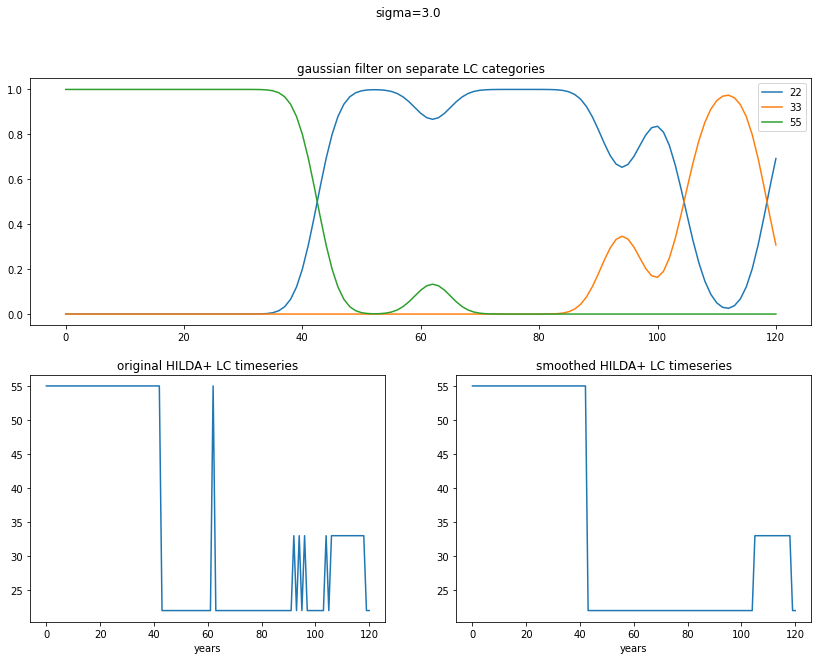

In [12]:
ds4=nc.Dataset('C:\\Users\\wittenbrink-m\\hildaplus_GLOB-2-0-f_states.nc')
### extract random area and find pixel with highest variability to plot it
### random coordinates
lat=40.25+np.random.randint(30)*0.5
lon=-10.25++np.random.randint(30)*0.5
res=0.5

h1=ds4["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
x=np.where(np.sum(h1[1:,:,:]!=h1[:-1,:,:],axis=0)==np.max(np.sum(h1[1:,:,:]!=h1[:-1,:,:],axis=0)))
slc=h1[:,x[0][0],x[1][0]]
### plot
def plotsmoothingwithsigma(slc,sigma):
    plt.figure(figsize=(14,10))
    plt.subplot(211)
    uniq=np.unique(slc,return_inverse=True)
    u=[uniq[1]==i for i in range(len(uniq[0]))]
    gf=[nd.gaussian_filter(ui.astype(float),sigma,mode='nearest') for ui in u]
    for i in range(len(uniq[0])):
        plt.plot(gf[i],c=f'C{i}',label=uniq[0][i])
    plt.legend()
    plt.title("gaussian filter on separate LC categories")
    plt.subplot(223)
    plt.plot(slc)
    ama=np.argmax(gf,axis=0)
    newslice=np.empty_like(gf[0])
    for i in range(len(uniq[0])):
        newslice[ama==i]=uniq[0][i]
    plt.title("original HILDA+ LC timeseries")
    plt.xlabel("years")
    plt.subplot(224)
    plt.title("smoothed HILDA+ LC timeseries")
    plt.plot(newslice)
    plt.xlabel("years")
    plt.suptitle(f"sigma={np.round(sigma,1)}")
plotsmoothingwithsigma(slc,3.)

In case you want to apply the smoothing on the original HILDA+ file during the age initialization process, you just need to add one line to the structure in the examples above:
```
...
for lon, lat in grid:
    ### retrieve Hilda data for gridcell
    h1=hilda["LULC_states"][:,(hildalats>=(lat-res/2.))*(hildalats<(lat+res/2.)),(hildalons>=(lon-res/2.))*(hildalons<(lon+res/2.))].data
    ### apply smoothing
->  h1=apply_smoothing_gridcell(h1,sigma=3.)  <-
    ### translate HILDA+ codes to LPJG codes
    ...
```